# **Transforming Patient Transcripts into Structured Data for Medical Research Analysis**

Import Necessary Packages

In [323]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from google.colab import drive
import re
import numpy as np
from collections import defaultdict
import spacy
import seaborn as sns
from wordcloud import WordCloud

Mount to drive and load dataset

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset
file_path = '/content/drive/My Drive/mtsamples_pruned.csv'

df = pd.read_csv(file_path)

Find Maximum Duplicates of UserId

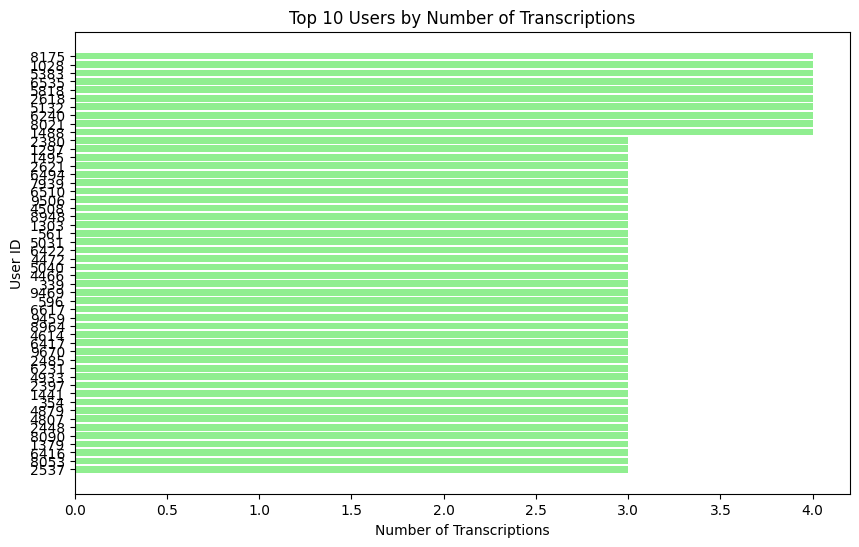

In [ ]:
# Count the number of transcriptions per user
user_engagement = df.groupby('user_id')['transcription'].count().reset_index(name='transcriptions_count')

# Plot a bar chart of the top 10 users by transcription count
top_users = user_engagement.sort_values('transcriptions_count', ascending=False).head(50)
plt.figure(figsize=(10, 6))
plt.barh(top_users['user_id'].astype(str), top_users['transcriptions_count'], color='lightgreen')
plt.xlabel('Number of Transcriptions')
plt.ylabel('User ID')
plt.title('Top 10 Users by Number of Transcriptions')
plt.gca().invert_yaxis()
plt.show()

The UserIds are repeated at most 4 times which needs to be handled to maintain atomicity

1.   Use spacy for text preprocessing
2.   Use biomedical-ner-all medical Named Entity Recognition Model from huggingface to identify the Entities in the transcript of patient


In [ ]:
# Load spaCy model for preprocessing
nlp_spacy = spacy.load("en_core_web_sm")

# Load the tokenizer and model from Hugging Face for NER
tokenizer = AutoTokenizer.from_pretrained("d4data/biomedical-ner-all")
model = AutoModelForTokenClassification.from_pretrained("d4data/biomedical-ner-all")
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")


Preprocessing text transcripts

1.   Convert to lower case
2.   Remove special characters
3.   Remove stop words

In [ ]:
def preprocess_text(text):
    # Check if text is not a string
    if not isinstance(text, str):
        return ""  # Return an empty string or some default text

    # Continue with preprocessing if text is a string
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    doc = nlp_spacy(text.lower())
    clean_sentences = []
    for sent in doc.sents:
        clean_text = ' '.join(token.lemma_ for token in sent if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV', 'NUM'] and not token.is_stop)
        clean_sentences.append(clean_text)
    return " ".join(clean_sentences)

In [ ]:
# Use a defaultdict to accumulate cleaned texts by user_id
user_texts = defaultdict(str)

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Extract user_id and text
    user_id = row['user_id']
    text = str(row['transcription']) if pd.notnull(row['transcription']) else ''

    # Clean the text
    cleaned_text = preprocess_text(text)

    # Append cleaned text to the existing entry for the user_id, separating by a space if there's already text there
    if user_texts[user_id]:
        user_texts[user_id] += " " + cleaned_text
    else:
        user_texts[user_id] = cleaned_text

# Convert the accumulated texts into a list of dictionaries, preparing for DataFrame conversion
cleaned_data = [{'user_id': user_id, 'cleaned_transcription': text} for user_id, text in user_texts.items()]

# Create a new DataFrame from the cleaned data
cleaned_df = pd.DataFrame(cleaned_data)

In [ ]:
csv_file_path = '/content/drive/My Drive/cleaned_transcriptions.csv'
cleaned_df.to_csv(csv_file_path, index=False)

saved cleaned and preprocessed transcripts for future use

In [ ]:
# Display the first few rows to understand the structure
print(cleaned_df.head())

# Basic info about the dataset
print(cleaned_df.info())


   user_id                              cleaned_transcription
0     2882  subjective 23yearold white female present comp...
1     3228  medical history difficulty climb stair difficu...
2     2244  history present illness see today pleasant gen...
3     4289  mmode 1 leave atrial enlargement left atrial d...
4     8754  1 left ventricular cavity size appear normal m...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3901 entries, 0 to 3900
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   user_id                3901 non-null   int64 
 1   cleaned_transcription  3901 non-null   object
dtypes: int64(1), object(1)
memory usage: 61.1+ KB
None


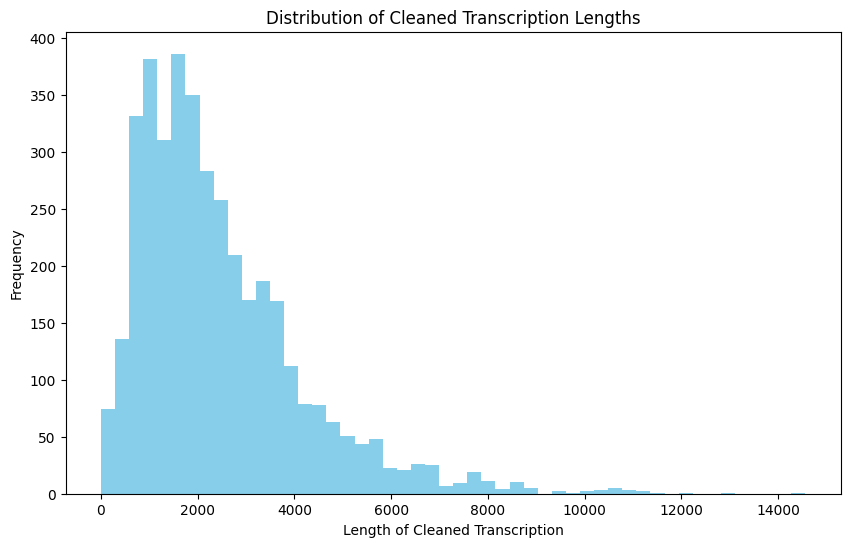

In [ ]:
# Calculate the length of each cleaned transcription
cleaned_df['transcription_length'] = cleaned_df['cleaned_transcription'].apply(len)

# Plot a histogram of transcription lengths
plt.figure(figsize=(10, 6))
plt.hist(cleaned_df['transcription_length'], bins=50, color='skyblue')
plt.title('Distribution of Cleaned Transcription Lengths')
plt.xlabel('Length of Cleaned Transcription')
plt.ylabel('Frequency')
plt.show()


In [ ]:
from collections import Counter
import itertools

# Tokenize the cleaned transcriptions and flatten the list of lists
words = list(itertools.chain(*cleaned_df['cleaned_transcription'].str.split()))

# Count the occurrences of each word
word_counts = Counter(words)

# Display the 10 most common words
print(word_counts.most_common(10))

[('patient', 23988), ('right', 10954), ('place', 8262), ('history', 8086), ('normal', 6710), ('left', 6645), ('pain', 5440), ('procedure', 5243), ('note', 4702), ('time', 4623)]


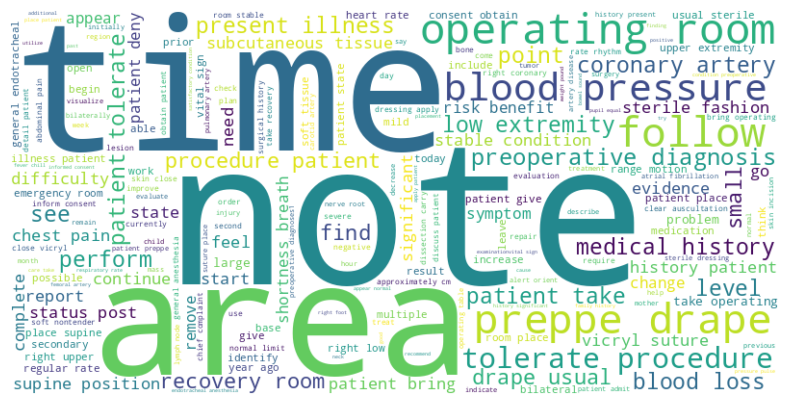

In [ ]:
from wordcloud import WordCloud

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(words))

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()

The analysis reveals that the most frequently occurring words are not pertinent to the medical field. To extract only the significant terms, further filtering is essential. This is where Named Entity Recognition (NER) comes into play, as it will pinpoint the medically relevant entities

First apply NER on the Transcript which returns us the Confidence score for each entity, Save the NER for each transcript

Then clean the transcripts to handle following
1. Remove Entities whose confidence is low < 0.6 ( We can increase the confidence level)
2. Remove words whose length is <= 3 except numbers
3. Remove words which starts wit ## these are subscripts which do not help

In [ ]:
# Define a minimum confidence score for filtering
min_score = 0.6

# Prepare a list to collect rows for the new DataFrame
ner_data = []

# Iterate over each row in the DataFrame
for index, row in cleaned_df.iterrows():
    user_id = row['user_id']
    cleaned_text = row['cleaned_transcription']

    # Apply the NER pipeline
    ner_results = ner_pipeline(cleaned_text)

    # Filter the NER results
    filtered_entities = [entity for entity in ner_results if entity['score'] > min_score and entity['entity_group'] != 'NUM' and len(entity['word']) > 3 and not entity['word'].startswith('##')]

    # Format the filtered entities for CSV storage (e.g., as a string)
    formatted_entities = '; '.join([f"{entity['entity_group']}: {entity['word']} ({entity['score']:.2f})" for entity in filtered_entities])

    # Append this row's data to ner_data
    ner_data.append({'user_id': user_id, 'ner_results': formatted_entities})

In [ ]:
# Convert ner_data to a DataFrame
ner_df = pd.DataFrame(ner_data)

# Save the DataFrame to a CSV file
ner_df.to_csv('/content/drive/My Drive/ner_results.csv', index=False)

Cleaned NER is saved foer future use

In [4]:
csv_file_path = '/content/drive/My Drive/ner_results.csv'

# Read the CSV file
ner_df = pd.read_csv(csv_file_path)

In [5]:
print(ner_df.head())
print(ner_df.info())

   user_id                                        ner_results
0     2882  Personal_background: white (0.99); History: al...
1     3228  Diagnostic_procedure: medical history (0.96); ...
2     2244  Diagnostic_procedure: today (0.71); Age: 42 ye...
3     4289  Sign_symptom: leave atrial enlargement (0.90);...
4     8754  Diagnostic_procedure: left ventricular cavity ...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3901 entries, 0 to 3900
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      3901 non-null   int64 
 1   ner_results  3879 non-null   object
dtypes: int64(1), object(1)
memory usage: 61.1+ KB
None


Entity Selection

In [8]:
from collections import Counter

# Initialize a list to store all extracted entities
all_entities = []

for index, row in ner_df.iterrows():
    ner_results = row['ner_results']
    # Check if ner_results is a string (i.e., not NaN or missing)
    if isinstance(ner_results, str):
        # Split the 'ner_results' string into individual entities
        entities = ner_results.split('; ')
        # Further split each entity to extract the entity type, discarding the score
        entity_types = [entity.split(':')[0] for entity in entities]
        # Extend the all_entities list with the extracted entity types
        all_entities.extend(entity_types)

# Use a Counter to count unique entities and their occurrences
entity_counter = Counter(all_entities)

# Compute the total number of unique entities
num_unique_entities = len(entity_counter)

print(f"Total number of unique entities: {num_unique_entities}")

Total number of unique entities: 37


There are 37 unique Entities

In [10]:
from collections import Counter

# Initialize a Counter to store unique entities and their frequencies
entity_counter = Counter()

# Iterate over each row in the DataFrame
for index, row in ner_df.iterrows():
    ner_results = row['ner_results']
    # Check if ner_results is a string
    if isinstance(ner_results, str):
        # Split the 'ner_results' string into individual entities
        entities = ner_results.split('; ')
        # Extract the entity type from each entity and add it to the Counter
        for entity in entities:
            entity_type = entity.split(':')[0]
            entity_counter[entity_type] += 1

# Print all unique entities and their frequencies, sorted by frequency in descending order
print("Entity Frequencies:")
for entity, frequency in entity_counter.most_common():
    print(f"{entity}: {frequency}")


Entity Frequencies:
Diagnostic_procedure: 127799
Sign_symptom: 53308
Therapeutic_procedure: 34298
Lab_value: 26465
Detailed_description: 23568
Biological_structure: 18853
Disease_disorder: 9346
Medication: 4474
Severity: 3636
Dosage: 2742
Duration: 2272
Clinical_event: 2071
Distance: 1986
History: 1751
Subject: 1537
Date: 1256
Sex: 846
Nonbiological_location: 821
Time: 783
Coreference: 598
Personal_background: 547
Administration: 369
Family_history: 196
Frequency: 185
Age: 180
Activity: 131
Color: 110
Other_event: 82
Volume: 59
Qualitative_concept: 52
Quantitative_concept: 46
Area: 29
Shape: 25
Texture: 14
Outcome: 4
Occupation: 2
Other_entity: 1


In [12]:
from collections import defaultdict, Counter

# Initialize a dictionary to count users per entity
entity_user_counts = defaultdict(set)

for index, row in ner_df.iterrows():
    user_id = row['user_id']
    ner_results = row['ner_results']
    if isinstance(ner_results, str):  # Ensure there's a valid NER results string
        entities = ner_results.split('; ')
        for entity in entities:
            entity_type = entity.split(':')[0]
            entity_user_counts[entity_type].add(user_id)  # Add the user_id to the set for this entity

# Convert sets to counts (i.e., how many users mentioned each entity)
entity_user_freq = {entity: len(users) for entity, users in entity_user_counts.items()}

# Sort entities by the number of users mentioning them
sorted_entity_user_freq = sorted(entity_user_freq.items(), key=lambda item: item[1], reverse=True)

# Optionally, to show entities occurring in most users, you can set a threshold, e.g., top 10
print("Top entities by user occurrence:")
for entity, count in sorted_entity_user_freq[:10]:  # Adjust the slice as needed
    print(f"{entity}: {count}")


Top entities by user occurrence:
Diagnostic_procedure: 3832
Detailed_description: 3694
Lab_value: 3684
Sign_symptom: 3622
Biological_structure: 3143
Therapeutic_procedure: 2973
Disease_disorder: 2360
Medication: 1759
Severity: 1549
Clinical_event: 1294


In [13]:
from collections import defaultdict

# Initialize a dictionary to store examples of each entity type
entity_examples = defaultdict(list)

for index, row in ner_df.iterrows():
    user_id = row['user_id']
    ner_results = row['ner_results']
    if isinstance(ner_results, str):  # Ensure valid NER results string
        entities = ner_results.split('; ')
        for entity in entities:
            entity_split = entity.split(':')
            if len(entity_split) >= 2:  # Ensure there's both an entity type and content
                entity_type = entity_split[0].strip()
                entity_content = ':'.join(entity_split[1:]).strip()  # Rejoin in case of multiple colons
                # Store up to 5 examples for each entity type
                if len(entity_examples[entity_type]) < 5:
                    entity_examples[entity_type].append(entity_content)

# Print 5 examples for each entity type
for entity_type, examples in entity_examples.items():
    print(f"{entity_type} (examples):")
    for example in examples:
        print(f"  - {example}")
    print("-" * 50)  # Separator for readability


Personal_background (examples):
  - white (0.99)
  - caucasian (0.80)
  - white (0.83)
  - white (0.86)
  - caucasian (0.88)
--------------------------------------------------
History (examples):
  - allergy (0.77)
  - allergy (0.74)
  - single drink year smoke (0.76)
  - dayfamily (0.73)
  - deny (0.71)
--------------------------------------------------
Medication (examples):
  - zyrtec (0.93)
  - prescription (0.91)
  - nasal spray (0.70)
  - asthma (0.99)
  - medication (0.99)
--------------------------------------------------
Diagnostic_procedure (examples):
  - work (0.81)
  - blood pressure (1.00)
  - culture (0.64)
  - studies (0.92)
  - evaluate (0.98)
--------------------------------------------------
Detailed_description (examples):
  - short time (0.82)
  - clearneck (0.86)
  - cheaper (0.94)
  - secondary (0.99)
  - secondary (0.98)
--------------------------------------------------
Sign_symptom (examples):
  - lose effectiveness (0.80)
  - allergies (0.86)
  - throat (0.95

In [14]:
# Define the list of entities to retain
entities_to_keep = {
    "Personal_background",
    "Sex",
    "Age",
    "Medication",
    "Disease_disorder",
    "Diagnostic_procedure",
    "Therapeutic_procedure",
    "Biological_structure",
    "Severity",
    "Sign_symptom",
    "Family_history",
    "History"
}

# Function to filter entities in ner_results
def filter_entities(ner_results):
    filtered = []
    if isinstance(ner_results, str):
        entities = ner_results.split('; ')
        for entity in entities:
            entity_type, rest = entity.split(':', 1)
            if entity_type in entities_to_keep:
                filtered.append(entity)
    return '; '.join(filtered)

# Apply the filtering function to the ner_results column
ner_df['filtered_ner_results'] = ner_df['ner_results'].apply(filter_entities)

# Optionally, if you want to replace the original ner_results with the filtered ones
# ner_df['ner_results'] = ner_df['filtered_ner_results'].copy()
# ner_df.drop(columns=['filtered_ner_results'], inplace=True)

# Display the first few rows to verify the filtering
print(ner_df.head())

   user_id                                        ner_results  \
0     2882  Personal_background: white (0.99); History: al...   
1     3228  Diagnostic_procedure: medical history (0.96); ...   
2     2244  Diagnostic_procedure: today (0.71); Age: 42 ye...   
3     4289  Sign_symptom: leave atrial enlargement (0.90);...   
4     8754  Diagnostic_procedure: left ventricular cavity ...   

                                filtered_ner_results  
0  Personal_background: white (0.99); History: al...  
1  Diagnostic_procedure: medical history (0.96); ...  
2  Diagnostic_procedure: today (0.71); Age: 42 ye...  
3  Sign_symptom: leave atrial enlargement (0.90);...  
4  Diagnostic_procedure: left ventricular cavity ...  


Considering the key attributes, prevalent features, and domain expertise, the entities chosen for focus are:

1. Personal Background
2. Sex
3. Age
4. Medication
5. Disease or Disorder
6. Diagnostic Procedure
7. Therapeutic Procedure
8. Biological Structure
9. Severity
10. Signs and Symptoms
11. Family History
12. Medical History

In [16]:
selected_entities = {
    'Personal_background': 'Race',
    'Sex': 'Sex',
    'Age': 'Age',
    'Medication': 'Medication',
    'Disease_disorder': 'Disease_Disorder',
    'Diagnostic_procedure': 'Diagnostic_Procedure',
    'Therapeutic_procedure': 'Therapeutic_Procedure',
    'Biological_structure': 'Biological_Structure',
    'Severity': 'Severity',
    'Sign_symptom': 'Sign_Symptom',
    'Family_history': 'Family_History',
    'History': 'History'
}

Restructuring the Patesnts Dataset with Selected Entities
In this process the duplicate userid transcrips for the same user is merged

---



In [17]:
# Initialize a dictionary to hold the structured data
structured_data = defaultdict(lambda: defaultdict(list))

# Process each row to extract and structure the entity data
for index, row in ner_df.iterrows():
    user_id = row['user_id']
    ner_results = row['ner_results']
    if isinstance(ner_results, str):
        entities = ner_results.split('; ')
        for entity_info in entities:
            entity_split = entity_info.split(':')
            if len(entity_split) < 2: continue
            entity_type, entity_value = entity_split[0], ':'.join(entity_split[1:])
            if entity_type in selected_entities:
                # Append the entity value to the list for this user and entity type
                structured_data[user_id][selected_entities[entity_type]].append(entity_value.strip())

# Convert the structured data into a DataFrame
final_data = {
    'user_id': [],
    **{entity: [] for entity in selected_entities.values()}  # Initialize columns for each entity
}

for user_id, entities in structured_data.items():
    final_data['user_id'].append(user_id)
    for entity, values in selected_entities.items():
        # Concatenate multiple values with '; ' or leave as '' if no values
        final_data[values].append('; '.join(entities.get(values, [])))

df_final = pd.DataFrame(final_data)

# Display the structure of the final DataFrame
print(df_final.head())


   user_id                            Race Sex                 Age  \
0     2882  white (0.99); caucasian (0.80)                           
1     3228                                                           
2     2244                                      42 year old (0.89)   
3     4289                                                           
4     8754                                                           

                                          Medication  \
0  zyrtec (0.93); prescription (0.91); nasal spra...   
1                                                      
2                          chantix medication (0.98)   
3                                                      
4                                                      

                                    Disease_Disorder  \
0  mastica (0.68); mastica (0.61); space infectio...   
1  heart disease (0.81); heart attack (1.00); cor...   
2  obesity (1.00); heart disease (0.99); diabetes...   
3                 

Preprcessing each attribute to make it structured

In [21]:
# Export the DataFrame as a CSV file
df_final.to_csv('/content/drive/My Drive/semi_ner_results.csv', index=False)


In [360]:
csv_file_path = '/content/drive/My Drive/semi_ner_results.csv'

# Read the CSV file
df_final = pd.read_csv(csv_file_path)

Preprocessing Race Attribute
1. Define possible races by removing duplicated races
2. Remove Duplicates within the UsedId
3. Remove Confidence score
4. Assign Unknown to null values


In [284]:
# Function to remove scores and strip extra spaces
def remove_scores_and_strip(value):
    # Regular expression to match scores like (0.99) and remove them
    cleaned_value = re.sub(r'\(\d\.\d+\)', '', value).strip()
    return cleaned_value

# Extract unique race strings from the "Race" column
unique_race_strings = df_final['Race'].unique()

# Split each string by '; ' to get individual race values and flatten the list
all_race_values = set()
for race_string in unique_race_strings:
    if pd.notna(race_string):  # Ensure the string is not NaN
        # Splitting by '; ' to handle multiple entries in a single string
        split_values = race_string.split('; ')
        # Removing scores and extra spaces from each race value
        races = [remove_scores_and_strip(value) for value in split_values]
        all_race_values.update(races)

# Now all_race_values contains all unique race values without scores
print("Unique Race Values:")
for race in sorted(all_race_values):
    print(race)


Unique Race Values:
african american
african american gentleman
africanamerican
black
caucasian
cuban
filipino
german
hispanic
korean
latin american
mexican
middle eastern descent
native american
vietnamese
white


In [361]:
def clean_race(race_str):
    if isinstance(race_str, str):
        # Remove scores and split by '; ' for multivalued entries
        races = [re.sub(r'\s\(\d\.\d+\)', '', r).strip().lower() for r in race_str.split(';')]

        # Step 2: Deduplicate and standardize race names
        standardized_races = {
            'african american': 'african american',
            'africanamerican': 'african american',
            'african american gentleman':  'african american',
            'black': 'african american',
            'cuban': 'cuban',
            'filipino': 'filipino',
            'german': 'german',
            'hispanic': 'hispanic',
            'korean': 'korean',
            'latin american': 'latin american',
            'mexican': 'mexican',
            'middle eastern descent': 'middle eastern descent',
            'native american': 'native american',
            'vietnamese': 'vietnamese',
            'white': 'white',
            'caucasian': 'white'
        }

        # Replace terms and handle 'white' and 'caucasian' case
        cleaned_races = set()  # Use a set to automatically deduplicate
        for race in races:
            if race in standardized_races:
                cleaned_races.add(standardized_races[race])

        # Step 3: Convert back to single string, handle multivalued entries as per rules
        # Assuming preference order is already considered by deduplication and standardization logic
        if cleaned_races:
            return next(iter(cleaned_races))  # Return one of the cleaned races (arbitrarily chosen if multiple)
        else:
            return 'unknown'  # Or another default value for entries with no recognized race terms
    else:
        return 'unknown'  # Handle NaN values

# Apply the cleaning function to the Race column
df_final['Race'] = df_final['Race'].apply(clean_race)

# Show unique race values after cleaning to verify
print(df_final['Race'].unique())


['white' 'unknown' 'african american' 'hispanic' 'filipino' 'vietnamese'
 'native american' 'middle eastern descent' 'german' 'korean'
 'latin american' 'cuban' 'mexican']


Count of Unique Race Categories:
unknown                   6828
white                      730
african american           128
hispanic                    26
native american             12
filipino                     4
vietnamese                   4
middle eastern descent       4
cuban                        4
mexican                      4
german                       2
korean                       2
latin american               2
Name: Race, dtype: int64




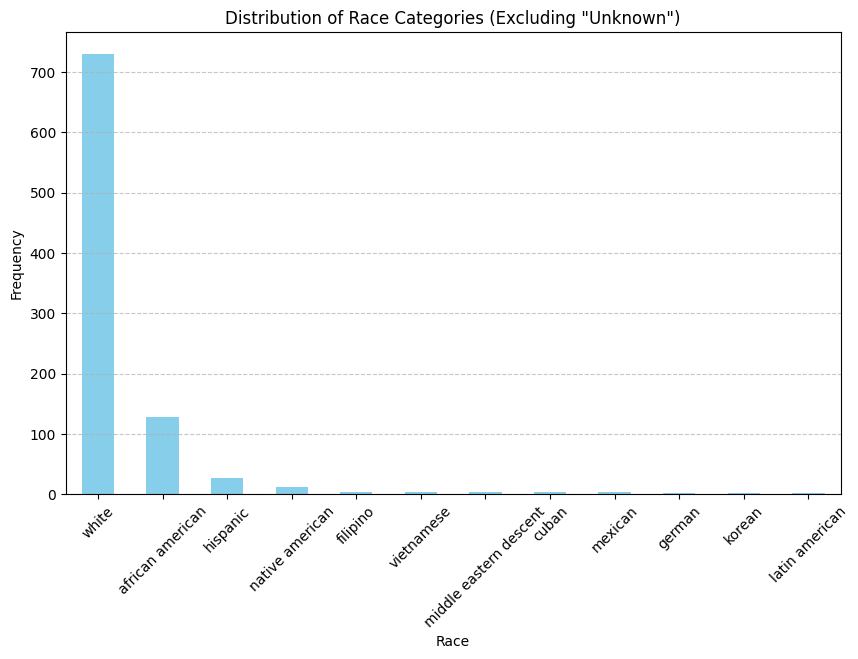

In [308]:
race_counts = df_final['Race'].value_counts()
print("Count of Unique Race Categories:")
print(race_counts)
print("\n")

# Filter out 'unknown' category
race_counts_filtered = race_counts[race_counts.index != 'unknown']

# Data Visualization
plt.figure(figsize=(10, 6))
race_counts_filtered.plot(kind='bar', color='skyblue')
plt.title('Distribution of Race Categories (Excluding "Unknown")')
plt.xlabel('Race')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Most of the Patients Race is White suggesting the region

Preprocessing Sex Attribute

1. Define possible Sex by removing duplicated Sex
2. Remove Duplicates within the UsedId
3. Remove Confidence score
4. Assign Unknown to null values

In [362]:
def remove_scores_and_strip(value):
    # Regular expression to match scores like (0.99) and remove them
    cleaned_value = re.sub(r'\(\d\.\d+\)', '', value).strip()
    return cleaned_value

# Extract unique sex strings from the "Sex" column
unique_sex_strings = df_final['Sex'].unique()

# Set to store all unique sex values
all_sex_values = set()

# Iterate over each sex string
for sex_string in unique_sex_strings:
    if pd.notna(sex_string):  # Ensure the string is not NaN
        # Splitting by '; ' to handle multiple entries in a single string
        split_values = sex_string.split('; ')
        # Removing scores and extra spaces from each sex value
        cleaned_values = [remove_scores_and_strip(value) for value in split_values]
        all_sex_values.update(cleaned_values)

# Now all_sex_values contains all unique sex values without scores
print("Unique Sex Values:")
for sex in sorted(all_sex_values):
    print(sex)


Unique Sex Values:
female
gentleman
girl
lady
male
person
woman


In [363]:
def clean_sex(sex_str):
    if isinstance(sex_str, str):
        # Remove confidence scores and convert to lowercase for standardization
        sex_values = [re.sub(r'\s\(\d\.\d+\)', '', sex).lower() for sex in sex_str.split('; ')]

        # Mapping for standardization
        standardized_sex = {
            'female': 'female',
            'gentleman': 'male',
            'girl': 'female',
            'lady': 'female',
            'male': 'male',
            'person': 'unknown',
            'woman': 'female',
        }

        # Standardize and deduplicate
        cleaned_sex = set(standardized_sex.get(value, 'unknown') for value in sex_values)

        # Handle multiple standardized values (if any)
        if 'male' in cleaned_sex and 'female' in cleaned_sex:
            return 'unknown'  # Ambiguous case
        elif 'male' in cleaned_sex:
            return 'male'
        elif 'female' in cleaned_sex:
            return 'female'
        else:
            return 'unknown'
    else:
        return 'unknown'  # Handle NaN values

# Apply the cleaning function to the Sex column
df_final['Sex'] = df_final['Sex'].apply(clean_sex)


Count of Unique Sex Categories:
unknown    6286
female     1122
male        342
Name: Sex, dtype: int64




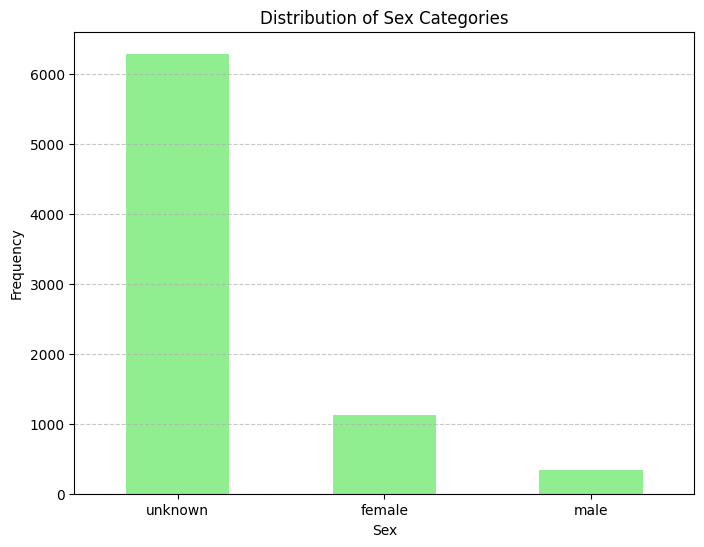

In [289]:
# Count the occurrences of each sex category
sex_counts = df_final['Sex'].value_counts()
print("Count of Unique Sex Categories:")
print(sex_counts)
print("\n")

# Data Visualization
plt.figure(figsize=(8, 6))
sex_counts.plot(kind='bar', color='lightgreen')
plt.title('Distribution of Sex Categories')
plt.xlabel('Sex')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Most of the sex is Unknown
- There are more female patients than male patients in the record

Preprocessing Age Attribute

1. Define possible Age by removing undesiarable Age Values
2. Remove Duplicates within the UsedId
3. Remove Confidence score
4. Assign NA to null values
5. Age is an Integer

In [364]:
def extract_age(age_str):
    if isinstance(age_str, str):
        # Remove confidence scores
        age_str = re.sub(r'\s\(\d\.\d+\)', '', age_str)

        # Search for patterns of age in years
        match = re.search(r'(\d+)\s*(year|year old|yearold)', age_str)
        if match:
            return int(match.group(1))  # Return age in years as an integer

        # Search for patterns of age in months and convert to years
        match = re.search(r'(\d+)\s*month', age_str)
        if match:
            months = int(match.group(1))
            return months // 12  # Convert months to years, rounding down

    # Handle other non-standard entries or missing values
    return np.nan

# Assuming df_final is your DataFrame
df_final['Age'] = df_final['Age'].apply(extract_age)

# Convert age to integer, with NaNs where age couldn't be determined
df_final['Age'] = df_final['Age'].astype('Int64')  # 'Int64' type supports NaN values

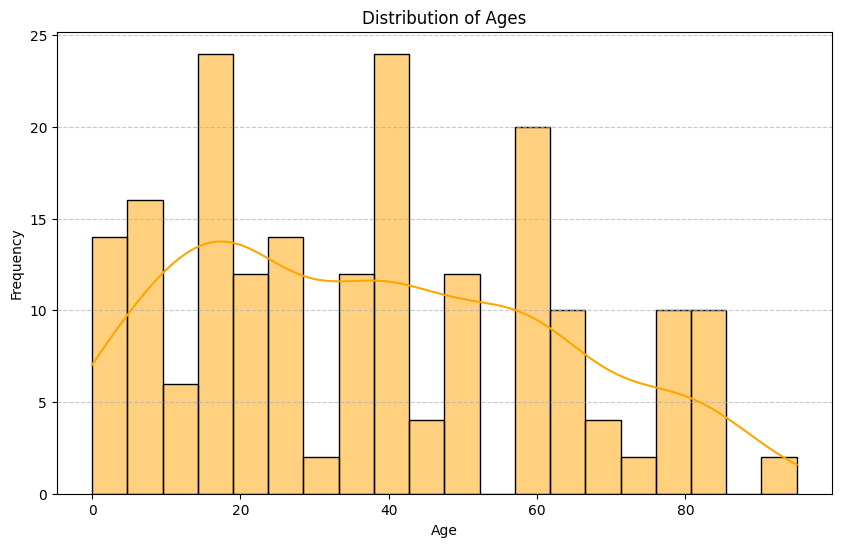

In [240]:
age_data = df_final['Age'].dropna()

# Data Visualization
plt.figure(figsize=(10, 6))
sns.histplot(age_data, bins=20, kde=True, color='orange')
plt.title('Distribution of Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Most of the patients age is between 18 - 60
- Max patients age is 18s and 40s followed by 60s

Preprocessing Medication Attribute

1. Medication is a multivaued attribute a patient can be under several mediacation
2. Remove Duplicates within the UsedId
3. Remove Confidence score
4. Assign Unknown to null values

In [365]:
def clean_medication(medication_str):
    # Check if the input is a valid string, otherwise return NaN
    if not isinstance(medication_str, str):
        return 'unknown'  # Set as 'unknown' for no values

    # Remove confidence scores and strip extra spaces
    medication_str = re.sub(r'\(\d\.\d+\)', '', medication_str).strip()

    # Split medication strings and remove duplicates
    medications = list(set(medication_str.split('; ')))

    # Create a dictionary to store the mappings of first words to their corresponding longer versions
    first_word_mapping = {}

    # Iterate through medications and populate the first_word_mapping
    for medication in medications:
        # Split the medication string into words
        words = medication.split()
        # Exclude the word "medication" from the words list
        words = [word for word in words if word.lower() not in ['medication', 'medication ']]
        # Join the words back into a string
        cleaned_medication = ' '.join(words)

        # Check if the cleaned medication string is not empty
        if cleaned_medication:
            first_word, *rest = cleaned_medication.split()
            if first_word.lower() not in first_word_mapping:
                first_word_mapping[first_word.lower()] = cleaned_medication
            elif len(cleaned_medication) > len(first_word_mapping[first_word.lower()]):
                first_word_mapping[first_word.lower()] = cleaned_medication

    # Use the values of first_word_mapping to get the cleaned medications
    cleaned_medications = list(first_word_mapping.values())

    # Join the cleaned medications back into a single string
    cleaned_medication_str = '; '.join(cleaned_medications)

    return cleaned_medication_str

# Apply the cleaning function to the Medication column
df_final['Medication'] = df_final['Medication'].apply(clean_medication)


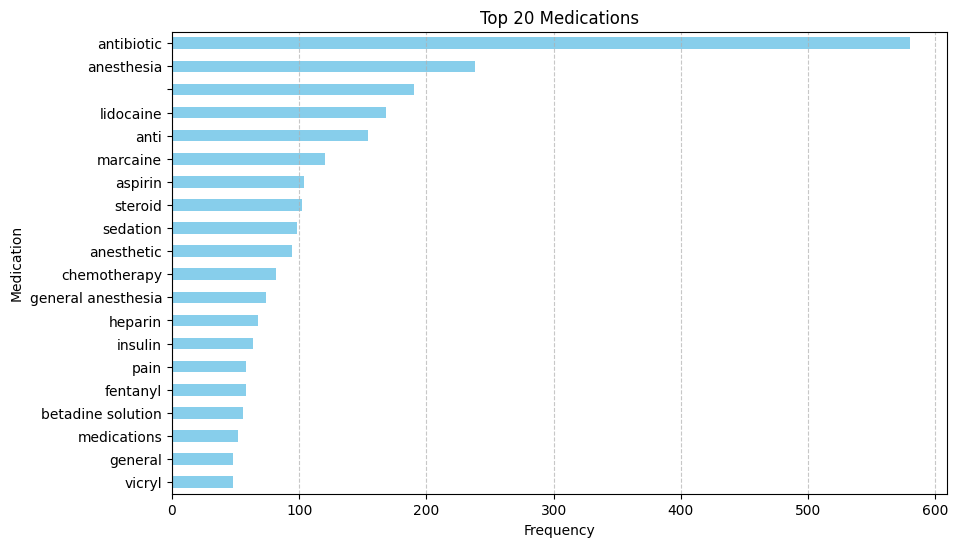

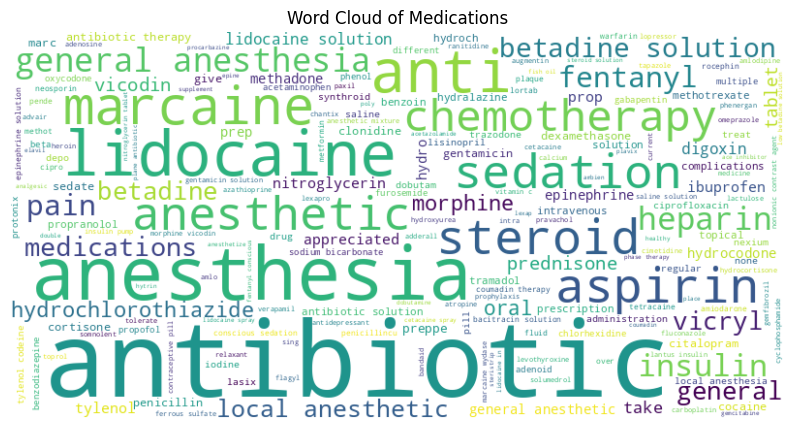

In [256]:
# Filter out 'Unknown' medications
filtered_medications = all_medications[all_medications != 'unknown']

# Calculate frequency of each medication
medication_counts = filtered_medications.value_counts()

# Plot the top N medications
top_n = 20  # Choose the number of top medications to visualize
plt.figure(figsize=(10, 6))
medication_counts.head(top_n).sort_values().plot(kind='barh', color='skyblue')
plt.title(f'Top {top_n} Medications')
plt.xlabel('Frequency')
plt.ylabel('Medication')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Create a word cloud of medications
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(medication_counts)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Medications')
plt.axis('off')
plt.show()


Antibiotic is the most occuring medication, followed by anesthesia

Preprocessing Disease_Disorder Attribute

1. Disease_Disorder is a multivaued attribute a patient can be under several Disorder
2. Remove Duplicates within the UsedId
3. Remove Confidence score
4. Assign Unknown to null values

In [366]:
def clean_disease_disorder(disease_str):
    if pd.isna(disease_str):
        return np.nan  # Return NaN if the value is NaN

    # Remove scores and split by '; ' for multivalued entries
    diseases = [re.sub(r'\s\(\d\.\d+\)', '', d).strip().lower() for d in disease_str.split(';')]

    # Step 2: Deduplicate and keep the longer version for repeated terms
    cleaned_diseases = {}
    for disease in diseases:
        parts = disease.split()
        first_word = parts[0] if parts else None
        if first_word not in cleaned_diseases or len(disease) > len(cleaned_diseases[first_word]):
            cleaned_diseases[first_word] = disease

    # Step 3: Convert back to a single string
    cleaned_disease_str = '; '.join(cleaned_diseases.values())

    return cleaned_disease_str

# Apply the cleaning function to the Disease_Disorder column
df_final['Disease_Disorder'] = df_final['Disease_Disorder'].apply(clean_disease_disorder)

# Show unique disease/disorder values after cleaning
print(df_final['Disease_Disorder'].unique())


['mastica; space infection; infection'
 'heart disease; coronary artery disease; congestive heart failure; arrh; peptic ulcer disease; infect; pancreatitis; liver hepatitis; cancer; deny; cellulitis; pseudotum'
 'obesity; heart attack coronary artery disease; diabetes; congestive heart failure; arrhythmia; atrial fibrillation pacemaker; pulmonary embolism cva; deny; venous insufficiency thrombophlebitis; copd; thyroid problem; pain; osteoarthritis; peptic ulcer disease; gallstone; gallbla; pancreatitis; cellulitis; pseudotumor cerebri en; risk'
 ... 'crepitus injury; dissection' 'force injury; sharp force injury'
 'kawasaki fever; conjunctivitis; arthritis']


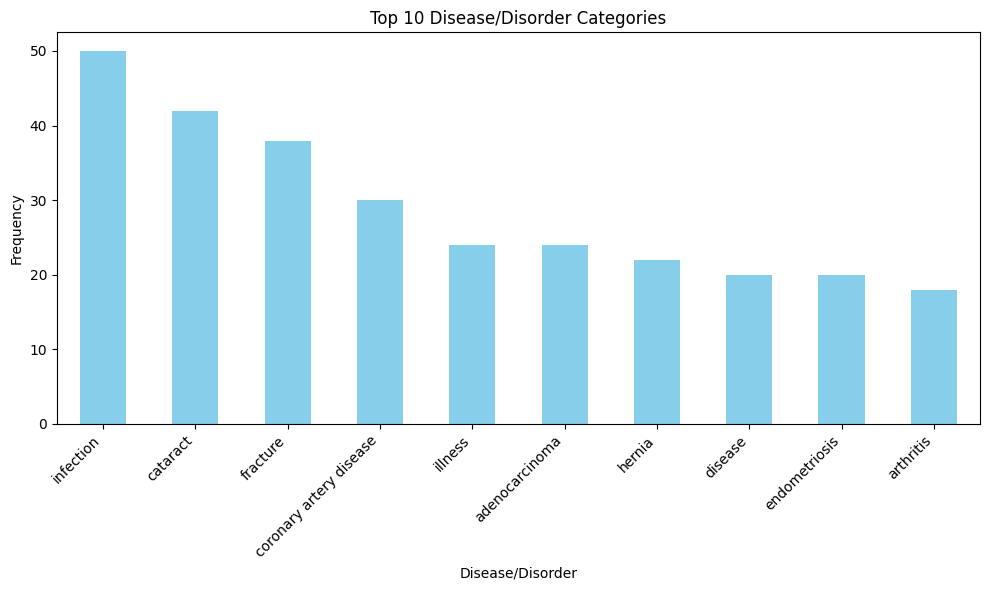

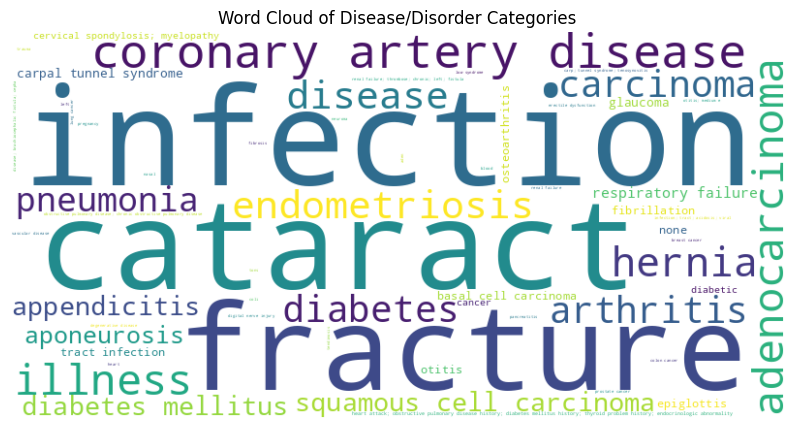

In [259]:
# Extract unique disease/disorder strings
unique_disease_disorders = df_final['Disease_Disorder'].unique()

# Frequency counts of disease/disorder categories
disease_disorder_counts = df_final['Disease_Disorder'].value_counts()

top_10_disease_disorders = disease_disorder_counts.head(10)

# Visualization
plt.figure(figsize=(10, 6))
top_10_disease_disorders.plot(kind='bar', color='skyblue')
plt.title('Top 10 Disease/Disorder Categories')
plt.xlabel('Disease/Disorder')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Alternatively, you can use a word cloud for visualizing frequent disease/disorder terms
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(disease_disorder_counts)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Disease/Disorder Categories')
plt.axis('off')
plt.show()


Infection, Cataract, Fracture Coronary Artery Disease are most common Diseases among the Patients

Preprocessing Diagnostic_Procedure Attribute

1. Diagnostic_Procedure is a multivaued attribute a patient can be under several Diagnostic_Procedure
2. Remove Duplicates within the UsedId
3. Remove Confidence score
4. Assign Unknown to null values

In [367]:
def clean_diagnostic_procedure(proc_str):
    if pd.isna(proc_str):
        return np.nan  # Return NaN if the value is NaN

    # Remove scores and split by '; ' for multivalued entries
    procedures = [re.sub(r'\s\(\d\.\d+\)', '', p).strip().lower() for p in proc_str.split(';')]

    # Deduplicate
    cleaned_procedures = set(procedures)

    # Convert back to a single string
    cleaned_proc_str = '; '.join(cleaned_procedures)

    return cleaned_proc_str

# Apply the cleaning function to the Diagnostic_Procedure column
df_final['Diagnostic_Procedure'] = df_final['Diagnostic_Procedure'].apply(clean_diagnostic_procedure)

# Show unique diagnostic procedure values after cleaning
print(df_final['Diagnostic_Procedure'].unique())


['culture; blood pressure; patientafter evaluation; work; evaluate; facial ct; studies'
 'tie shoe; high cholesterol; pneumoperitoneum; ochsner clamp incise figureof; general endotrac; walk block; emotional eater; left fundus; table; direct vision; port trocar engage; overweight; fascia; orthopedic skin; medical history; skin incision; place abdomen; eat history; pacemaker; carbohydrate; clip; weigh system; sweet like; reverse trendelenburg position; laparoscope insert; flight stair difficulty; lifting; poor experience program; additional; difficulty; social; adequate; object; climb; cardio difficulty; gastroesophageal reflux disease; stitch; airline seat; intact; vicryl place fascial edge; electro; feel appropriate; preppe; pulmonary embol; body weight; lose; blood pressure; weigh; floor exercise; deny; gallbladder; place; public seating; epigastric area; usual; afebrile vital sign stable procedure; cranial nerve iixii; anesthesia; ideal'
 'heart; soft; surgical attempt; work; bacon; 

Preprocessing Therapeutic_Procedure Attribute

1. Therapeutic_Procedure is a multivaued attribute a patient can be under several Therapeutic_Procedure
2. Remove Duplicates within the UsedId
3. Remove Confidence score
4. Assign Unknown to null values

In [368]:
def clean_therapeutic_procedure(proc_str):
    if pd.isna(proc_str):
        return np.nan  # Return NaN if the value is NaN

    # Remove scores and split by '; ' for multivalued entries
    procedures = [re.sub(r'\s\(\d\.\d+\)', '', p.strip().lower()) for p in proc_str.split(';')]

    # Exclude the specified words
    exclude_words = {'remove', 'refer', 'ground', 'help', 'hospital', 'want','',' '}
    procedures = [re.sub(r'\s+', ' ', p) for p in procedures if p and p not in exclude_words]  # Remove multiple spaces

    # Deduplicate
    cleaned_procedures = set(procedures)

    # Convert back to a single string
    cleaned_proc_str = '; '.join(cleaned_procedures)

    return cleaned_proc_str

# Apply the cleaning function to the Therapeutic_Procedure column
df_final['Therapeutic_Procedure'] = df_final['Therapeutic_Procedure'].apply(clean_therapeutic_procedure)

# Show unique therapeutic procedure values after cleaning
print(df_final['Therapeutic_Procedure'].unique())


['attach; lay supine operating room table monitor; intraorally; incision; prep; lidocaine; operating room table sterile fashion; extraction; mast; intubation in; space; blunt dissection; hemostat; border mandible perform; procedure; general anesthesia abscess incision drainage removal; anest; moisten raytec sponge place; oral surgery; operating; oral maxillofacial surgery surgeon; pacuindication procedure; epinephrine inject; aerobic; crystalloidest; general anesthesia; coverage; tooth; left masticator space; left; anesthetic; anesthesia effect needle; nostril; approach'
 'operating room; supine operating room' 'knee surgery' ...
 'medical; properly; medical treatment'
 'nutritionist; cholecystectomy; worker; tonsillectomy; gastric bypass; ekg clearance surgery; knee surgery'
 'primary care doctor; primary doctor']


<ipython-input-322-dd5d34683ff6>:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


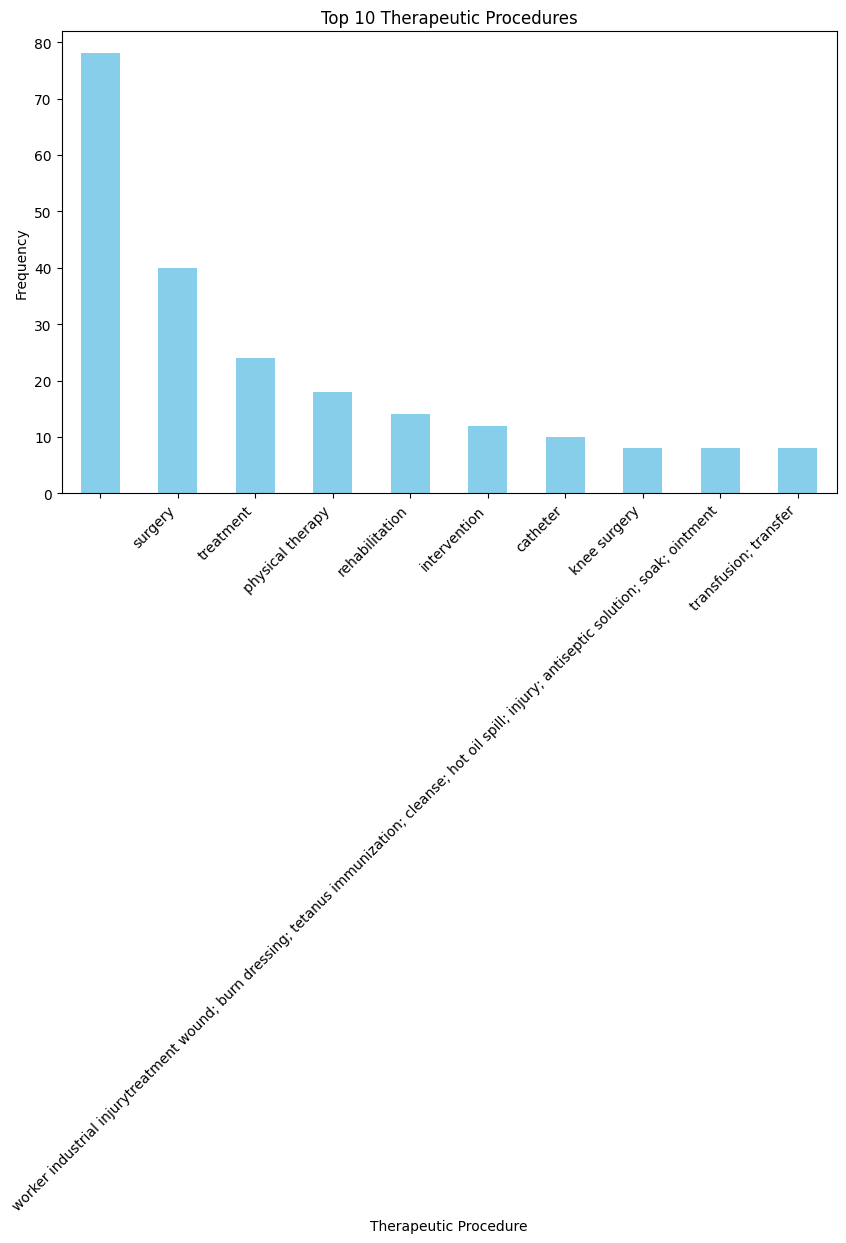

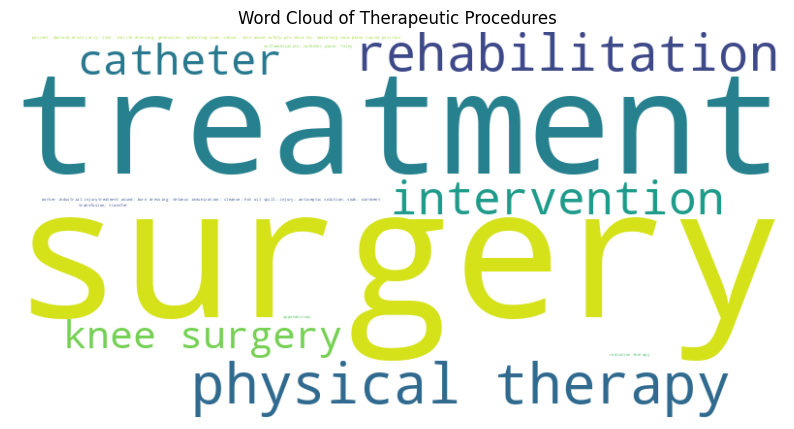

In [322]:
# Extract unique therapeutic procedure strings
unique_therapeutic_procedures = df_final['Therapeutic_Procedure'].unique()

# Frequency counts of therapeutic procedure categories
therapeutic_procedure_counts = df_final['Therapeutic_Procedure'].value_counts()

# Get the top 10 therapeutic procedures
top_10_therapeutic_procedures = therapeutic_procedure_counts.head(10)
# Visualization: Bar plot for the top 10 therapeutic procedures
plt.figure(figsize=(10, 6))
top_10_therapeutic_procedures.plot(kind='bar', color='skyblue')
plt.title('Top 10 Therapeutic Procedures')
plt.xlabel('Therapeutic Procedure')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Alternatively, you can use a word cloud for visualizing frequent therapeutic procedures
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(therapeutic_procedure_counts)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Therapeutic Procedures')
plt.axis('off')
plt.show()


Most of the Therapeutic_Procedure were surgery, physical therapy, Knee surgary, Treatement

Preprocessing Biological_Structure Attribute

1. Biological_Structure is a multivaued attribute a patient can be under several Biological_Structure
2. Remove Duplicates within the UsedId
3. Remove Confidence score
4. Assign Unknown to null values

In [369]:
def clean_biological_structure(structure_str):
    if pd.isna(structure_str):
        return np.nan  # Return NaN if the value is NaN

    # Remove scores and split by '; ' for multivalued entries
    structures = [re.sub(r'\s\(\d\.\d+\)', '', s).strip().lower() for s in structure_str.split(';')]

    # Deduplicate
    cleaned_structures = set(structures)

    # Convert back to a single string
    cleaned_structure_str = '; '.join(cleaned_structures)

    return cleaned_structure_str

# Apply the cleaning function to the Biological_Structure column
df_final['Biological_Structure'] = df_final['Biological_Structure'].apply(clean_biological_structure)

# Show unique biological structure values after cleaning
print(df_final['Biological_Structure'].unique())


['submandibular area area; left submandibular region; submandibular space; submandibular region; muscular'
 'right hand; joint; gall; head; ankle; foot; chest; knee' nan ...
 'umbilicus; shoulder; posterior; midline shoulder; anterior wrist; upper extremity; anterior shoulder; anterior; right forearm; midline right; inner aspect right breast quadrant; symmetrical buttock; left breast; right posterior shoulder; aspect left buttock; extremity; left forearm; posterior neck'
 'upper extremity; neck; right; chest; thigh'
 'neck; midline neck; skin subdermal tissue neck']


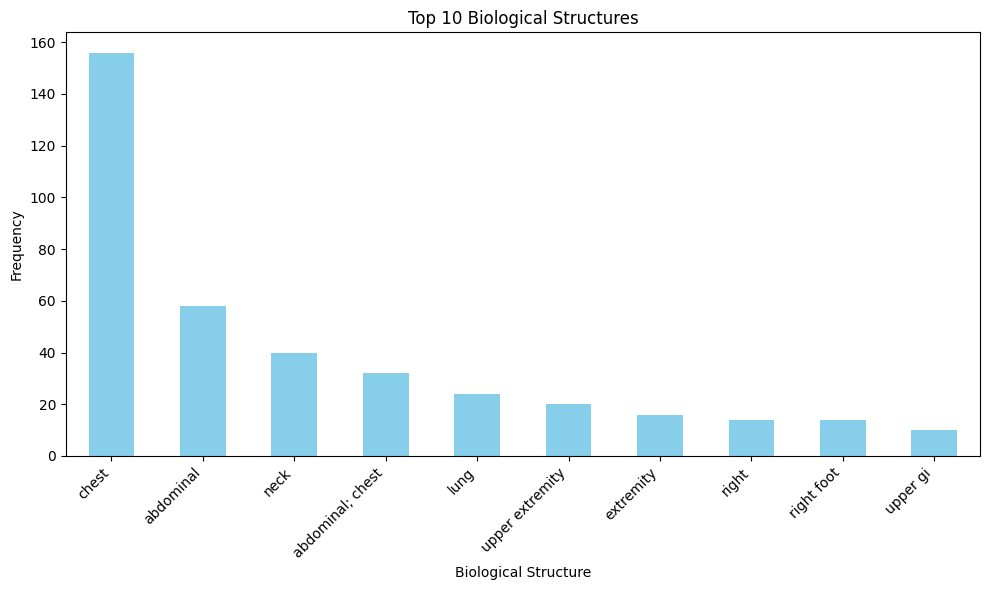

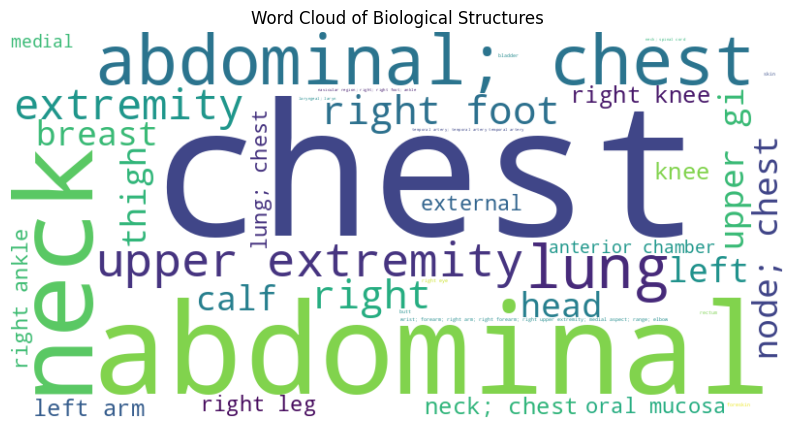

In [266]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Extract unique biological structure strings
unique_biological_structures = df_final['Biological_Structure'].unique()

# Frequency counts of biological structure categories
biological_structure_counts = df_final['Biological_Structure'].value_counts()

# Get the top 10 biological structures
top_10_biological_structures = biological_structure_counts.head(10)

# Visualization: Bar plot for the top 10 biological structures
plt.figure(figsize=(10, 6))
top_10_biological_structures.plot(kind='bar', color='skyblue')
plt.title('Top 10 Biological Structures')
plt.xlabel('Biological Structure')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Alternatively, you can use a word cloud for visualizing frequent biological structures
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(biological_structure_counts)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Biological Structures')
plt.axis('off')
plt.show()


The Biological_Structure attributes gives us an idea about the region of disease.
- Most of the patients have Chest, lung, abodominal neck related issue

Preprocessing Severity Attribute

1. Define possible Severity by removing undesiarable Severity Values
2. Remove Duplicates within the UsedId
3. Remove Confidence score
4. Severity is a single valued attribute

In [163]:
# Show unique severity values before cleaning
print("Unique Severity Values Before Cleaning:")
print(df_final['Severity'].unique())

Unique Severity Values Before Cleaning:
[nan 'mild (0.99); significant (0.98); significant (0.99); severe (0.96)'
 'mild (1.00); mild (0.96); moderate (0.85)' ...
 'severe; severe; moderate; severe'
 'significant history; severe; mild; severe' 'minimal; slight']


In [370]:
def clean_severity(severity_str):
    if pd.isna(severity_str):
        return 'unknown'

    # Define priority order for severity levels
    severity_priority = ['severe', 'significant', 'moderate', 'mild', 'minimal', 'slight']

    # Split the severity string by '; ' and remove any scores
    severity_values = re.sub(r'\s\(\d\.\d+\)', '', severity_str).split('; ')

    # Initialize highest priority severity level
    highest_priority = None

    # Iterate through severity values to find the highest priority level
    for severity in severity_values:
        if severity.strip().lower() in severity_priority:
            highest_priority = severity.strip().lower()
            break

    return highest_priority if highest_priority else 'unknown'

# Apply the cleaning function to the Severity column
df_final['Severity'] = df_final['Severity'].apply(clean_severity)

# Show unique severity values after cleaning
print("Unique Severity Values After Cleaning:")
print(df_final['Severity'].unique())


Unique Severity Values After Cleaning:
['unknown' 'mild' 'significant' 'severe' 'minimal' 'moderate' 'slight']


Frequency of Each Severity Level:
unknown        5262
mild            798
severe          766
significant     586
moderate        182
minimal          82
slight           74
Name: Severity, dtype: int64


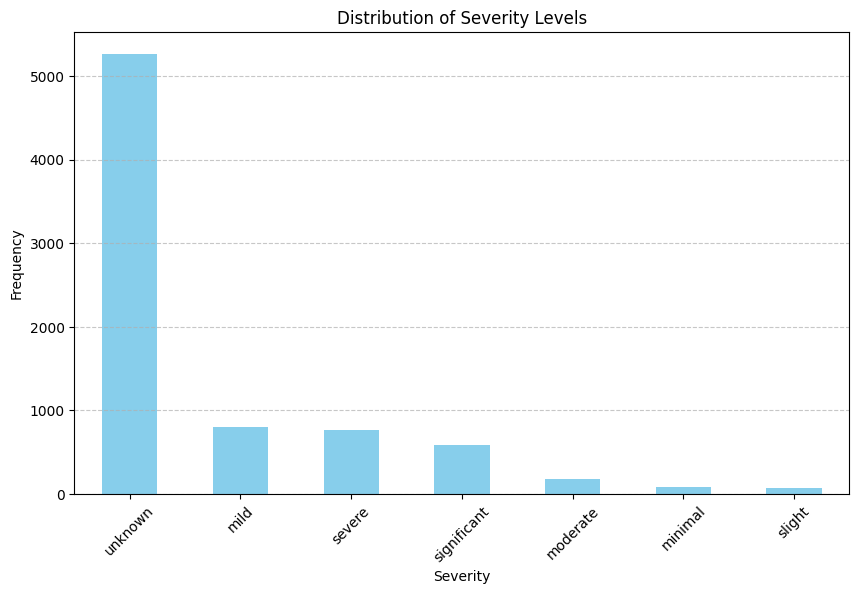

In [271]:
# Calculate frequency of each severity level
severity_counts = df_final['Severity'].value_counts()
print("Frequency of Each Severity Level:")
print(severity_counts)

# Plot the distribution of severity levels
plt.figure(figsize=(10, 6))
severity_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Severity Levels')
plt.xlabel('Severity')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

-Most of the patients severity is unknown, followed by mild, severe

Preprocessing Sign_Symptom Attribute

1. Sign_Symptom is a multivaued attribute a patient have several symptoms
2. Remove Duplicates within the UsedId
3. Remove Confidence score
4. Assign Unknown to null values

In [371]:
def clean_sign_symptom(symptom_str):
    if pd.isna(symptom_str):
        return 'unknown'

    # Define the words to exclude
    exclude_words = {'symptom', 'change', 'state'}

    # Remove scores and split by '; ' for multivalued entries
    symptoms = [re.sub(r'\s\(\d\.\d+\)', '', s).strip().lower() for s in symptom_str.split(';')]

    # Exclude the specified words
    symptoms = [s for s in symptoms if s not in exclude_words]

    # Deduplicate symptoms and join them into a single string
    cleaned_symptoms = '; '.join(set(symptoms))

    return cleaned_symptoms

# Apply the cleaning function to the Sign_Symptom column
df_final['Sign_Symptom'] = df_final['Sign_Symptom'].apply(clean_sign_symptom)

# Show unique sign/symptom values after cleaning
print("Unique Sign/Symptom Values After Cleaning:")
print(df_final['Sign_Symptom'].unique())


Unique Sign/Symptom Values After Cleaning:
['throat; tracheal deviation; erythematous exudate; abscess; supple aden; difficulty; toothache; erythematous; allergies; lose effectiveness; swollen clear drainage; allergic; clearassessment; blood loss; swelling'
 'asthma; insufficiency; swell; high; shortness breath; snore muscle; pain'
 'block; pain leg; orient 3 cranial; head neck; shoe; deny chest; positive; pain knee pain; wheezing; tired; gain; pain foot ankle; lose weight; overweight lose 70 excess; infection; pain; supple; complication; sluggish; asthma difficulty; gout; step sleep apnea; weight loss; exercise; high blood pressure; pulmonary embolism leakage; shortness breath; climb stair difficulty; venous throm'
 ... 'breath; hypertension; distress alert'
 'cold; cornea; iris; lesion; lividity; lesion hyo; entirety; broken hyoid bone hemorrhaging; absence abrasion associate; anatomic injury; scar; belt cause; injury pub; petechial hemorrhage; injury lip tooth gum obstruction; injur

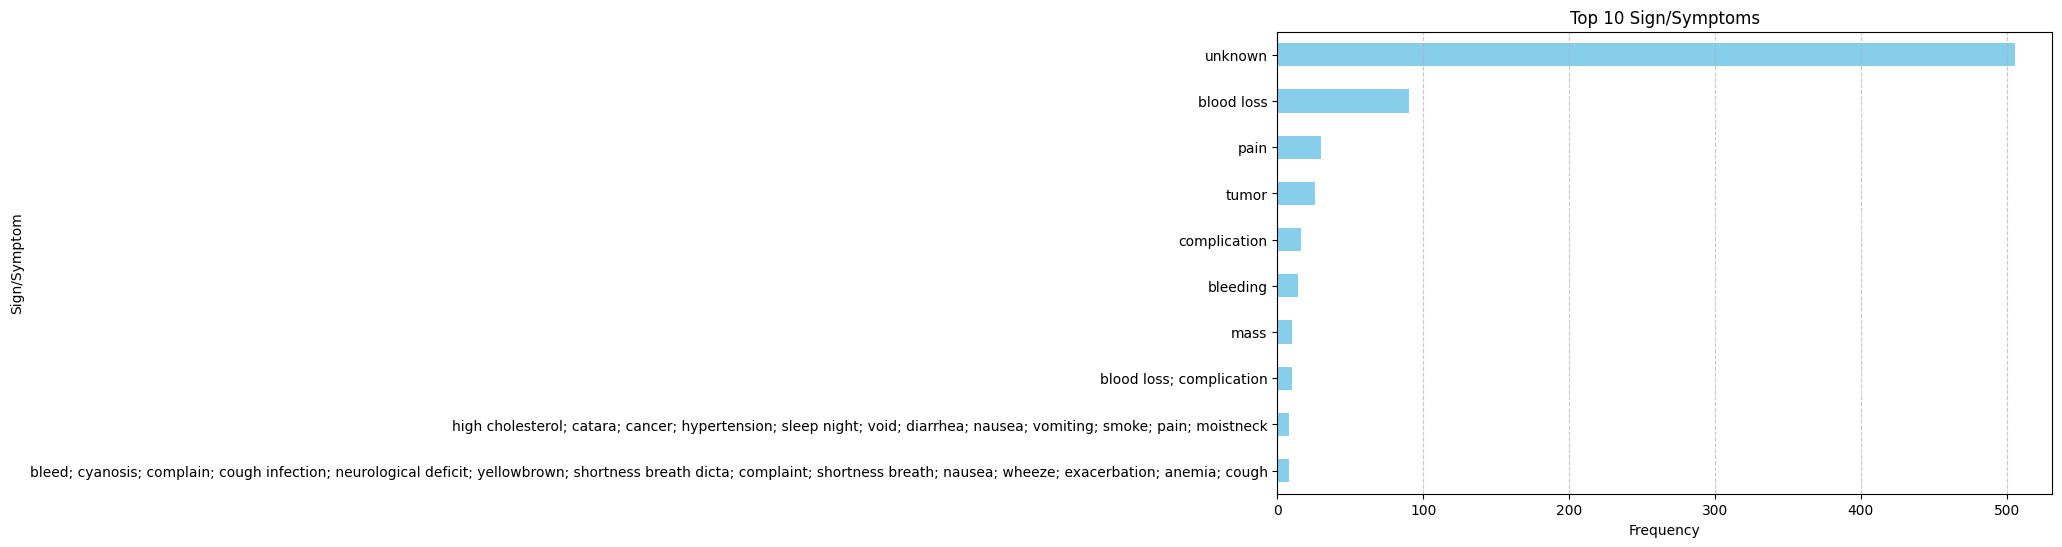

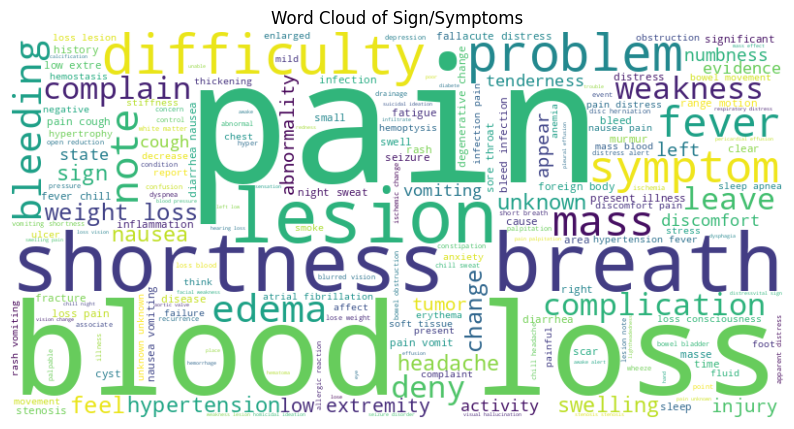

In [325]:
# Calculate the frequency of each sign/symptom
sign_symptom_counts = df_final['Sign_Symptom'].value_counts()

# Plot the top N sign/symptom occurrences
top_n = 10  # Choose the number of top sign/symptoms to visualize
plt.figure(figsize=(10, 6))
sign_symptom_counts.head(top_n).sort_values().plot(kind='barh', color='skyblue')
plt.title(f'Top {top_n} Sign/Symptoms')
plt.xlabel('Frequency')
plt.ylabel('Sign/Symptom')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Create a word cloud of sign/symptoms
from wordcloud import WordCloud

all_sign_symptoms = ' '.join(df_final['Sign_Symptom'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_sign_symptoms)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Sign/Symptoms')
plt.axis('off')
plt.show()

The most common symptons among patients are pain, lesion, shortness breath, blood loss.

Preprocessing Family_History Attribute

1. Family_History is a binary attribute with values [Yes, No]
2. Remove Duplicates within the UsedId
3. Remove Confidence score
4. Severity is a single valued attribute

In [372]:
def clean_family_history(history_str):
    if pd.isna(history_str):
        return 'NO'
    else:
        return 'YES'

# Apply the cleaning function to the Family_History column
df_final['Family_History'] = df_final['Family_History'].apply(clean_family_history)

# Show unique values after cleaning
print("Unique Family History Values After Cleaning:")
print(df_final['Family_History'].unique())


Unique Family History Values After Cleaning:
['NO' 'YES']


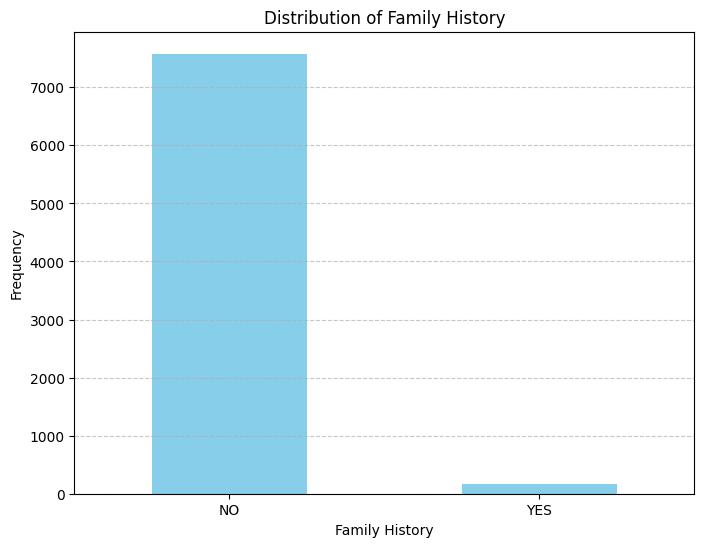

In [278]:
# Calculate the frequency of each family history category
family_history_counts = df_final['Family_History'].value_counts()

# Plot the distribution of family history categories
plt.figure(figsize=(8, 6))
family_history_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Family History')
plt.xlabel('Family History')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Most of the patients do not have a family history

Preprocessing History Attribute

1. History is a multivaued attribute a patient have several other disease before
2. Remove Duplicates within the UsedId
3. Remove Confidence score
4. Assign Unknown to null values


In [373]:
df_final_hist = df_final

In [374]:
def clean_history(history_str):
    if pd.isna(history_str):
        return 'None'

    # Remove scores and split by '; ' for multivalued entries
    history_items = [re.sub(r'\s\(\d\.\d+\)', '', item).strip().lower() for item in history_str.split(';')]

    # Filter out the specified words
    exclude_words = {'past', 'hyper', 'drug', 'drug use', 'nonsmoker', 'history'}
    history_items = [item for item in history_items if item not in exclude_words]

    # Deduplicate history items and join them into a single string
    cleaned_history = '; '.join(set(history_items))

    return cleaned_history

# Apply the cleaning function to the History column
df_final_hist['History'] = df_final_hist['History'].apply(clean_history)


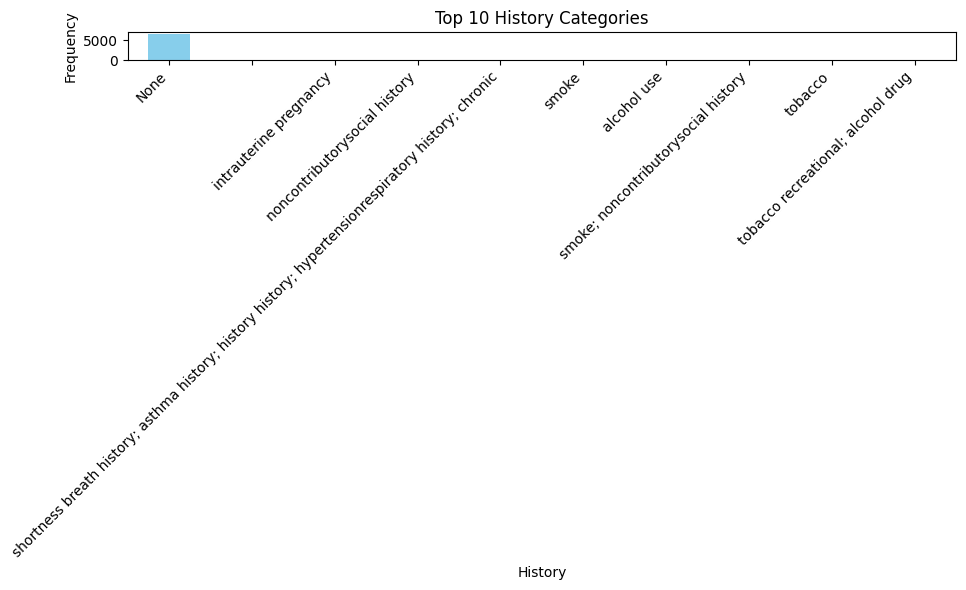

In [375]:
# Calculate the frequency of each history category
history_counts = df_final_hist['History'].value_counts()

# Select the top 10 history categories
top_10_history = history_counts.head(10)

# Plot the top 10 history categories
plt.figure(figsize=(10, 6))
top_10_history.plot(kind='bar', color='skyblue')
plt.title('Top 10 History Categories')
plt.xlabel('History')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Most of the patients history is unknown some of the common histories were intrauterine pregnancy, allergy, asthma

In [376]:
df_final_hist.head()

,user_id,Race,Sex,Age,Medication,Disease_Disorder,Diagnostic_Procedure,Therapeutic_Procedure,Biological_Structure,Severity,Sign_Symptom,Family_History,History
0,2882,white,unknown,<NA>,option; nasal spray; asthma; loratadine think;...,mastica; space infection; infection,culture; blood pressure; patientafter evaluati...,attach; lay supine operating room table monito...,submandibular area area; left submandibular re...,unknown,throat; tracheal deviation; erythematous exuda...,NO,allergy
1,3228,unknown,unknown,<NA>,unknown,heart disease; coronary artery disease; conges...,tie shoe; high cholesterol; pneumoperitoneum; ...,operating room; supine operating room,right hand; joint; gall; head; ankle; foot; ch...,unknown,asthma; insufficiency; swell; high; shortness ...,YES,dayfamily; single drink year smoke; deny
2,2244,unknown,unknown,42,chantix,obesity; heart attack coronary artery disease;...,heart; soft; surgical attempt; work; bacon; be...,knee surgery,NaN,unknown,block; pain leg; orient 3 cranial; head neck; ...,NO,None
3,4289,unknown,unknown,<NA>,unknown,artery disease,leave ventricular pressure; technique; diastol...,catheter; swanganz,descend coronary artery circumflex; main coron...,mild,vessel focal; leave atrial enlargement; regurg...,NO,None
4,8754,unknown,unknown,<NA>,unknown,NaN,bring; breast leave; general endotrac; accompl...,breast; graft; room place table supine positio...,right atrium,mild,aortic root appear; aortic valve stenosis; per...,NO,None


In [377]:
# Export DataFrame to CSV file
df_final_hist.to_csv('/content/drive/My Drive/Medical_NER_DSTH.csv', index=False)

# Display the first few rows of the DataFrame
print(df_final_hist.head())

   user_id     Race      Sex   Age  \
0     2882    white  unknown  <NA>   
1     3228  unknown  unknown  <NA>   
2     2244  unknown  unknown    42   
3     4289  unknown  unknown  <NA>   
4     8754  unknown  unknown  <NA>   

                                          Medication  \
0  option; nasal spray; asthma; loratadine think;...   
1                                            unknown   
2                                            chantix   
3                                            unknown   
4                                            unknown   

                                    Disease_Disorder  \
0                mastica; space infection; infection   
1  heart disease; coronary artery disease; conges...   
2  obesity; heart attack coronary artery disease;...   
3                                     artery disease   
4                                                NaN   

                                Diagnostic_Procedure  \
0  culture; blood pressure; patientafter 